In [100]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from IPython.core.display import HTML

In [127]:
df=pd.read_csv("data/2016_Building_Energy_Benchmarking.csv")

# Cleaning

On supprime les lignes outliers défini dans le tableau.

On supprime les colonnes YearsEnergy et comments car trop vide.

On souhaite uniquement prédire TotalGHGEmissions, donc je supprime "SiteEnergyUse(kBtu)" qui est une autre target et "GHGEmissionsIntensity" qui est la target en fonction de la surface.

On souhaite uniquement les bâtiments hors habitations, on supprime donc les lignes qui contiennent "Multifamily"

On supprime les colonnes Electricity (kwh) et NaturalGas(therms) car la même que Electricity (kbtu) et NAturalGas(kbtu) à l'unité près.

Suppression des colonnes WN qui sont liés à la météo, hors on cette donnée ne nous intéresse pas, car notre emission des GHG est plutôt lié à la consommation d'énergie.

Suppression des features fortement corrélées.

Suppression des NaN et valeurs à 0 ou <0 dans la Target.

Avant de lancer la partie ML, je vais faire un KNN imputer sur la colonne ENERGY et ZIPCODE

In [137]:
# Outlier cleaned
data_cleaned = df[df['Outlier'].isnull()]

# Drop features qui me semble inutile
data_cleaned  = data_cleaned.drop(["ListOfAllPropertyUseTypes","Address","City","OSEBuildingID","TaxParcelIdentificationNumber","PropertyName" ,"State",'Outlier', 'YearsENERGYSTARCertified', "Comments", "GHGEmissionsIntensity", "SiteEnergyUse(kBtu)","DefaultData", "ComplianceStatus" ], axis=1)

# Drop des lignes "Multifamily"
data_cleaned = data_cleaned[~data_cleaned['BuildingType'].str.contains("Multifamily") & ~data_cleaned['PrimaryPropertyType'].str.contains("Multifamily")]

# Drop des colonnes doubles avec unités différentes
data_cleaned.drop(['Electricity(kWh)', 'NaturalGas(therms)'], axis=1, inplace=True)

# Drop des features météorologiques: 
data_cleaned.drop(['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)'], axis=1, inplace=True)

# Création de l'âge des bâtiments:
data_cleaned['BuildingAge'] = data_cleaned['DataYear'] - data_cleaned['YearBuilt']
data_cleaned.drop(['YearBuilt', "DataYear"], axis=1, inplace=True)

# Drop des features fortement corrélées:
data_cleaned.drop(['LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'], axis = 1, inplace=True)
data_cleaned.drop(['PropertyGFABuilding(s)', 'SourceEUI(kBtu/sf)', 'Electricity(kBtu)','SiteEUI(kBtu/sf)','NaturalGas(kBtu)', "NumberofBuildings"], axis = 1, inplace=True)

# Suppression des lignes =0 ou <0
data_cleaned = data_cleaned[~(data_cleaned.TotalGHGEmissions<=0)]

# Drop nan de la target
data_cleaned = data_cleaned[~(data_cleaned.TotalGHGEmissions.isnull())]

# drop de la seule data dans cette catégorie
data_cleaned = data_cleaned[~(data_cleaned.BuildingType=="Nonresidential WA")]

# Correction des quartiers en double
data_cleaned['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)
data_cleaned['Neighborhood']=data_cleaned['Neighborhood'].map(lambda x: x.upper())

print(data_cleaned.shape)

(1639, 14)


In [140]:
data_cleaned.to_csv("data_cleaned.csv", index=0)

# Observation

In [136]:
data_cleaned.ListOfAllPropertyUseTypes.value_counts()

Office                                                                                    134
K-12 School                                                                               130
Office, Parking                                                                           119
Non-Refrigerated Warehouse                                                                101
Non-Refrigerated Warehouse, Office                                                         61
                                                                                         ... 
Data Center, Office, Other, Parking                                                         1
Bar/Nightclub, Office, Personal Services (Health/Beauty, Dry Cleaning, etc)                 1
Medical Office, Parking, Retail Store                                                       1
Office, Other - Entertainment/Public Assembly, Other - Mall, Restaurant                     1
Fitness Center/Health Club/Gym, Office, Other - Recreation, 

In [138]:
data_cleaned.columns

Index(['BuildingType', 'PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore',
       'SteamUse(kBtu)', 'TotalGHGEmissions', 'BuildingAge'],
      dtype='object')

In [ ]:
# NaN
df.isnull().sum().sort_values(ascending=False)

In [6]:
df.Outlier.value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [ ]:
building_types = sorted(data_cleaned['BuildingType'].unique())
primary_property_types = sorted(data_cleaned['PrimaryPropertyType'].unique())
display(building_types)
display(len(building_types))
display(primary_property_types)
display(len(primary_property_types))

In [ ]:
# on check le pourcentage de remplissage des colonnes
columns_nan_info ={}
for column in data_cleaned.keys():
    nan_count = data_cleaned[column].isnull().sum()
    columns_nan_info[column] = nan_count / data_cleaned.shape[0] * 100

df_columns_nan_info = pd.DataFrame(data=np.array(list(columns_nan_info.items())),columns=['column','nan %'])
df_columns_nan_info['nan %'] = pd.to_numeric(df_columns_nan_info['nan %'])
df_columns_nan_info = df_columns_nan_info.sort_values(by=['nan %'])

print(df_columns_nan_info.shape)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_columns_nan_info)

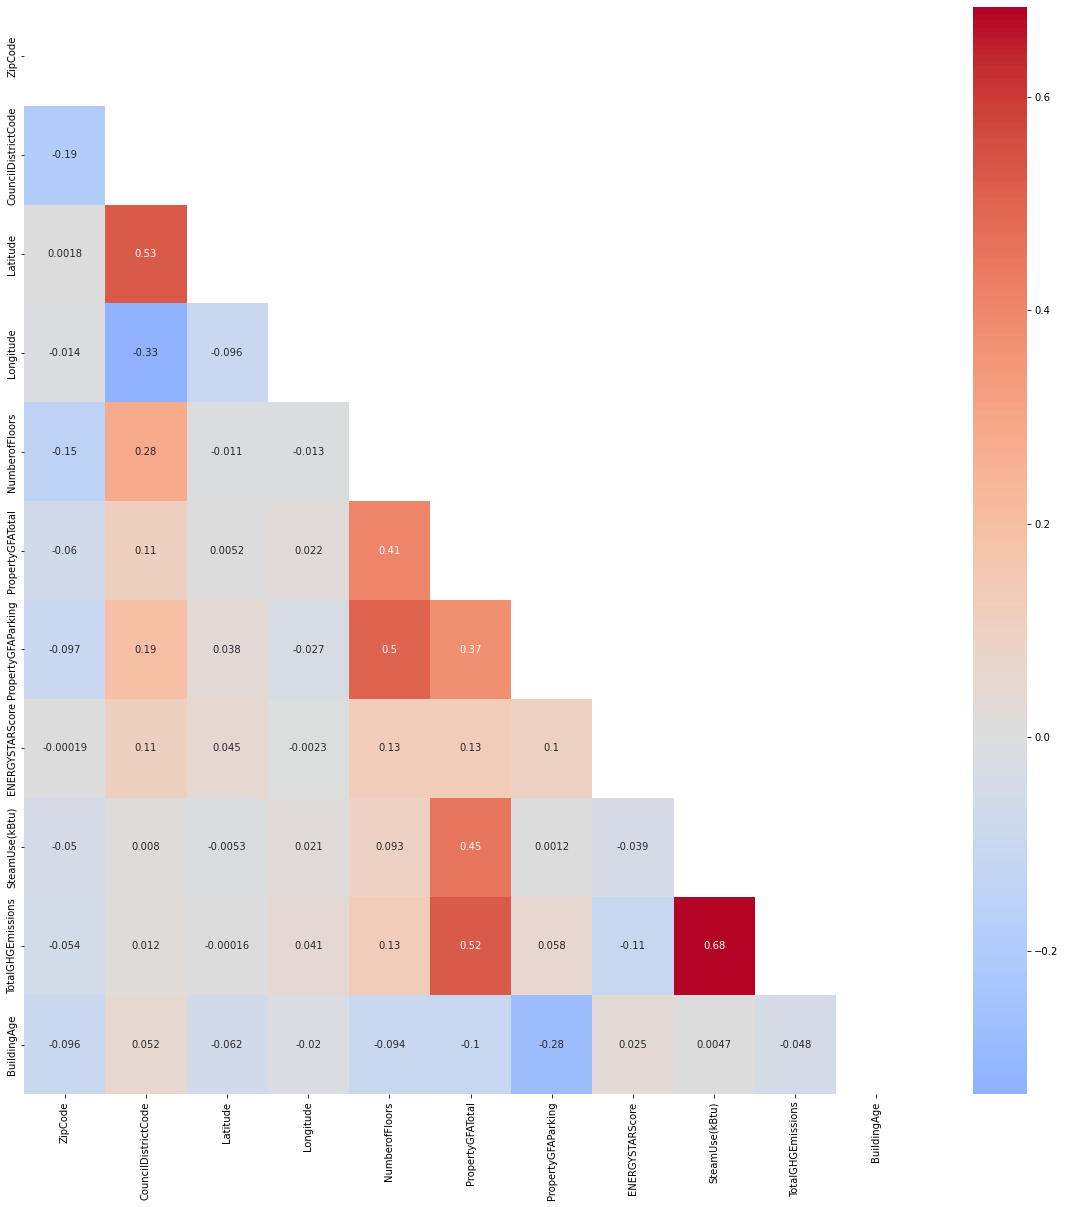

In [61]:
corr = data_cleaned.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(corr, annot=True, mask=mask, center=0, cmap="coolwarm")

In [73]:
data_cleaned[~(data_cleaned.TotalGHGEmissions.isnull())]

,BuildingType,PrimaryPropertyType,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ListOfAllPropertyUseTypes,ENERGYSTARScore,SteamUse(kBtu),TotalGHGEmissions,BuildingAge
0,NonResidential,Hotel,405 Olive way,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,12,88434,0,Hotel,60.0,2003882.00,249.98,89
1,NonResidential,Hotel,724 Pine street,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,11,103566,15064,"Hotel, Parking, Restaurant",61.0,0.00,295.86,20
2,NonResidential,Hotel,1900 5th Avenue,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,41,956110,196718,Hotel,43.0,21566554.00,2089.28,47
3,NonResidential,Hotel,620 STEWART ST,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,10,61320,0,Hotel,56.0,2214446.25,286.43,90
4,NonResidential,Hotel,401 LENORA ST,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,18,175580,62000,"Hotel, Parking, Swimming Pool",75.0,0.00,505.01,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,Nonresidential COS,Office,1600 S Dakota St,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1,12294,0,Office,46.0,0.00,20.94,26
3372,Nonresidential COS,Other,719 8th Ave S,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,1,16000,0,Other - Recreation,NaN,0.00,32.17,12
3373,Nonresidential COS,Other,1920 1st Ave W,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1,13157,0,"Fitness Center/Health Club/Gym, Other - Recrea...",NaN,0.00,223.54,42
3374,Nonresidential COS,Mixed Use Property,8319 8th Ave S,NaN,7883603155,1,GREATER DUWAMISH,47.52832,-122.32431,1,14101,0,"Fitness Center/Health Club/Gym, Food Service, ...",NaN,0.00,22.11,27


In [85]:
data_cleaned.ZipCode.isnull().sum()

16

In [88]:

imputer = KNNImputer(n_neighbors=5)
imputer.fit_transform(data_cleaned.select_dtypes(float))

array([[ 9.8101000e+04,  4.7612200e+01, -1.2233799e+02,  6.0000000e+01,
         2.0038820e+06,  2.4998000e+02],
       [ 9.8101000e+04,  4.7613170e+01, -1.2233393e+02,  6.1000000e+01,
         0.0000000e+00,  2.9586000e+02],
       [ 9.8101000e+04,  4.7613930e+01, -1.2233810e+02,  4.3000000e+01,
         2.1566554e+07,  2.0892800e+03],
       ...,
       [ 9.8116000e+04,  4.7636440e+01, -1.2235784e+02,  7.6200000e+01,
         0.0000000e+00,  2.2354000e+02],
       [ 9.8130600e+04,  4.7528320e+01, -1.2232431e+02,  6.6800000e+01,
         0.0000000e+00,  2.2110000e+01],
       [ 9.8130000e+04,  4.7539390e+01, -1.2229536e+02,  4.6400000e+01,
         0.0000000e+00,  4.1270000e+01]])

In [99]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1640 entries, 0 to 3375
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   BuildingType                   1640 non-null   object 
 1   PrimaryPropertyType            1640 non-null   object 
 2   Address                        1640 non-null   object 
 3   ZipCode                        1624 non-null   float64
 4   TaxParcelIdentificationNumber  1640 non-null   object 
 5   CouncilDistrictCode            1640 non-null   int64  
 6   Neighborhood                   1640 non-null   object 
 7   Latitude                       1640 non-null   float64
 8   Longitude                      1640 non-null   float64
 9   NumberofFloors                 1640 non-null   int64  
 10  PropertyGFATotal               1640 non-null   int64  
 11  PropertyGFAParking             1640 non-null   int64  
 12  ListOfAllPropertyUseTypes      1640 non-null   o

# Colinéarité (VIF)

In [ ]:
X = data_cleaned.select_dtypes(float)

In [148]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X),columns = X.columns)

In [153]:
X["ZipCode"] = round(X.ZipCode)

In [156]:
X["ENERGYSTARScore"] = round(X.ENERGYSTARScore)

In [158]:
test = data_cleaned.dropna()

In [161]:
vif_data = pd.DataFrame() 
vif_data["feature"] = test.select_dtypes(float).columns 
  
vif_data["VIF"] = [variance_inflation_factor(test.select_dtypes(float).values, i) 
                          for i in range(len(test.select_dtypes(float).columns))] 
  
print(vif_data)

             feature           VIF
0            ZipCode  1.384153e+07
1           Latitude  9.561476e+05
2          Longitude  1.420785e+07
3    ENERGYSTARScore  6.377197e+00
4     SteamUse(kBtu)  1.770590e+00
5  TotalGHGEmissions  1.863498e+00


In [162]:
pip show sklearn

Name: sklearn
Version: 0.0
Summary: A set of python modules for machine learning and data mining
Home-page: https://pypi.python.org/pypi/scikit-learn/
Author: UNKNOWN
Author-email: UNKNOWN
License: 
Location: c:\users\simplon\anaconda3\lib\site-packages
Requires: scikit-learn
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [13]:
X.describe()

,ZipCode,Latitude,Longitude,NumberofBuildings,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3360.000000,3376.000000,3376.000000,3368.000000,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,...,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,98116.949107,47.624033,-122.334795,1.106888,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,...,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,18.615205,0.047758,0.027203,2.108402,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,...,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,98006.000000,47.499170,-122.414250,0.000000,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,98105.000000,47.599860,-122.350662,1.000000,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,...,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,98115.000000,47.618675,-122.332495,1.000000,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,...,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,98122.000000,47.657115,-122.319407,1.000000,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,...,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,98272.000000,47.733870,-122.220966,111.000000,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,...,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000
